# Import

In [1]:
import os, sys
parent_dir = os.path.abspath('../..')

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import utils_os
import mi
    
from datasets.wild_pie import load_pie


torch.manual_seed(time.time())

%load_ext autoreload
%autoreload 2

# Global Variables

In [3]:
DEVICE = 'cuda:0' 

class Hyperparams(utils_os.ConfigDict):

    def __init__(self): 
        self.device = DEVICE
        self.learning_rate = 5e-4
        self.n_epochs = 400
        self.grad_clip = None
        self.batch_size = 256
        self.image_shape = (32, 32)
        self.update_inner_every_num_epoch = 2

BASE_HYPERPARAMS = Hyperparams()

ROOT = '../..'
MODEL_SAVE_DIR = f'{ROOT}/results/pie'
DATASET_DIR = f'{ROOT}/data/pie'

NUM_COLOR_CHANNELS = 3
NUM_CLASSES = 2

DIM_LEARNT = 256

# Data Loader

In [4]:
(
    train_set, val_set, test_set,
    train_loader, val_loader, test_loader,
) = load_pie(
    downsample_pct=0.5, batch_size=BASE_HYPERPARAMS.batch_size, img_size=BASE_HYPERPARAMS.image_shape[0],
    target_transform=transforms.Compose([
        lambda x: x - 1,
        lambda x: F.one_hot(torch.LongTensor([x]), num_classes=NUM_CLASSES)[0],
        lambda x: x.float(),
    ]),
    save_dir=DATASET_DIR
)


def loader2tensor(dataloader):
    all_data, all_target = [], []
    for batch_idx, (data, target) in enumerate(dataloader):
        all_data.append(data)
        all_target.append(target)
    print('loader2tensor finished.')
    return torch.cat(all_data, dim=0), torch.cat(all_target, dim=0)


all_data, all_label = loader2tensor(train_loader)
all_data_test, all_label_test = loader2tensor(test_loader)

loader2tensor finished.
loader2tensor finished.


In [5]:
from tasks.disentanglement.experiment import Autoencoder, train, test
from train_test_routine import exp_run


def inner_batch_provider():
    idx = torch.randperm(len(all_data))
    xx, yy = all_data[idx[:10000]], all_label[idx[:10000]]
    return xx, yy


def get_model_path(hyperparams, epoch=None):
    if epoch is not None:
        return f'{MODEL_SAVE_DIR}/{hyperparams.estimator}/model_{hyperparams.get_name("alpha", "beta", "gamma")}_{epoch}'
    return f'{MODEL_SAVE_DIR}/{hyperparams.estimator}/model_{hyperparams.get_name("alpha", "beta", "gamma")}'

In [6]:
import copy

hyperparams = copy.deepcopy(BASE_HYPERPARAMS)
hyperparams.alpha = 1.0
hyperparams.beta = 0.001
hyperparams.gamma = 0.001
hyperparams.n_slice = 250
hyperparams.estimator = 'SLICE'

autoencoder = Autoencoder(DIM_LEARNT, NUM_CLASSES, hyperparams).to(DEVICE)

autoencoder = exp_run(
    (train_loader, ), (test_loader, ),
    train, test,
    inner_batch_provider, get_model_path,
    hyperparams,
    device='cuda:0',
    model=autoencoder,
    scheduler_func=lambda optimizer: torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[300], gamma=0.1)
)

dim learnt 256 dim expert 2
epoch: 0, loss: 0.006423367050421589, mse: 0.005939324276850504, acc: 89.27247619628906, redundancy: 0.06772107813580364
epoch: 1, loss: 0.004170684682607066, mse: 0.003685820099039405, acc: 92.6629638671875, redundancy: 0.10169541377428115
epoch: 2, loss: 0.003918633198219479, mse: 0.0034526750107533206, acc: 93.62063598632812, redundancy: 0.09128994951207264
epoch: 3, loss: 0.0037196184891988247, mse: 0.0032877776424820515, acc: 94.65554809570312, redundancy: 0.06706787923843983
epoch: 4, loss: 0.003579522939581497, mse: 0.0031374365903948454, acc: 94.57831573486328, redundancy: 0.07705036779025606
epoch: 5, loss: 0.003439106165851448, mse: 0.0029833273158646097, acc: 94.9413070678711, redundancy: 0.09385396605905365
epoch: 6, loss: 0.0033082013684964063, mse: 0.002867310714232279, acc: 95.55143737792969, redundancy: 0.08497721508291423
epoch: 7, loss: 0.003174018142197062, mse: 0.0027279801045854888, acc: 95.46648406982422, redundancy: 0.08851023347062223

mse= tensor(1.3950)


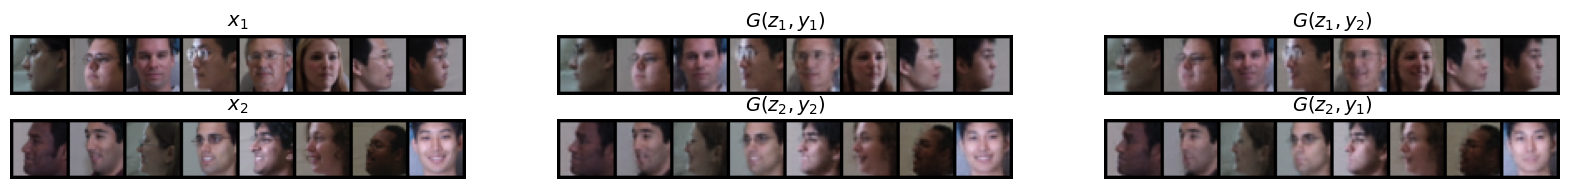

In [7]:
import torchvision

def swap_z1_z2(network):
    cate_a = 0
    cate_b = 1
    
    data, target = all_data_test[0:1000], all_label_test[0:1000]
    
    x_a = data[target.argmax(dim=1) == cate_a]
    x_b = data[target.argmax(dim=1) == cate_b]
    y = target
    num_sample = 300

    x_a = x_a[:num_sample]
    x_b = x_b[:num_sample]
    
    y_a = y[target.argmax(dim=1) == cate_a][:num_sample]
    y_b = y[target.argmax(dim=1) == cate_b][:num_sample]
    
    z_a, _ = network.separate_feature(x_a)
    z_b, _ = network.separate_feature(x_b)
    
    rx_zayb = network.decode(z_a, y_b).detach()
    rx_zbya = network.decode(z_b, y_a).detach()
    rx_a = network.decode(z_a, y_a).detach()
    rx_b = network.decode(z_b, y_b).detach()
    
    mse = torch.norm((x_a - rx_a).view(len(x_a), -1), dim=1)
    print('mse=', mse.mean())
    
    num_sample = 8

    x_a = x_a[:num_sample]
    x_b = x_b[:num_sample]
    
    z_a = z_a[:num_sample]
    z_b = z_b[:num_sample]
    rx_zayb = rx_zayb[:num_sample]
    rx_zbya = rx_zbya[:num_sample]
    rx_a = rx_a[:num_sample]
    rx_b = rx_b[:num_sample]

    plt.figure(figsize=(20, 2))
    fz = 14

    # GT y
    ax = plt.subplot(2, 3, 1)
    ax.set_title(r"$x_1$", fontsize=fz)
    ax.set_axis_off()
    grid_img = torchvision.utils.make_grid(x_a, nrow=8)
    plt.imshow(grid_img.permute(1, 2, 0))
    
    ax = plt.subplot(2, 3, 4)
    ax.set_title(r"$x_2$", fontsize=fz)
    ax.set_axis_off()
    grid_img = torchvision.utils.make_grid(x_b, nrow=8)
    plt.imshow(grid_img.permute(1, 2, 0))
        
    ax = plt.subplot(2, 3, 6)
    ax.set_title(r"$G(z_2, y_1)$", fontsize=fz)
    ax.set_axis_off()
    grid_img = torchvision.utils.make_grid(rx_zbya, nrow=8)
    plt.imshow(grid_img.permute(1, 2, 0))
    
    ax = plt.subplot(2, 3, 3)
    ax.set_title(r"$G(z_1, y_2)$", fontsize=fz)
    ax.set_axis_off()
    grid_img = torchvision.utils.make_grid(rx_zayb, nrow=8)
    plt.imshow(grid_img.permute(1, 2, 0))
    
    ax = plt.subplot(2, 3, 2)
    ax.set_title(r"$G(z_1, y_1)$", fontsize=fz)
    ax.set_axis_off()
    grid_img = torchvision.utils.make_grid(rx_a, nrow=8)
    plt.imshow(grid_img.permute(1, 2, 0))
    
    ax = plt.subplot(2, 3, 5)
    ax.set_title(r"$G(z_2, y_2)$", fontsize=fz)
    ax.set_axis_off()
    grid_img = torchvision.utils.make_grid(rx_b, nrow=8)
    plt.imshow(grid_img.permute(1, 2, 0))
    
    
swap_z1_z2(autoencoder.to('cpu'))

In [ ]:
import copy

hyperparams = copy.deepcopy(BASE_HYPERPARAMS)
hyperparams.alpha = 1.0
hyperparams.beta = 1.0
hyperparams.gamma = 0.1
hyperparams.n_slice = 250
hyperparams.n_epochs = 200
hyperparams.estimator = 'NONE'  # 'PEARSON' or 'DC' or 'TC' or 'RENYI'
hyperparams.inner_lr = 1e-3
hyperparams.inner_epochs = 10
hyperparams.inner_batch_size = 5000

autoencoder = Autoencoder(DIM_LEARNT, NUM_CLASSES, hyperparams).to(DEVICE)

autoencoder = exp_run(
    (train_loader, ), (test_loader, ),
    train, test,
    inner_batch_provider, get_model_path,
    hyperparams,
    device='cuda:0',
    model=autoencoder,
    scheduler_func=lambda optimizer: torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75], gamma=0.1)
)